In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
uav_data = pd.read_csv("uav_flight_dataset.csv")
uav_data.columns

Index(['timestamp', 'roll', 'pitch', 'yaw', 'roll_body', 'pitch_body',
       'yaw_body', 'output[0]', 'output[1]', 'output[2]', 'voltage_v',
       'current_a', 'gyro_rad[0]', 'gyro_rad[1]', 'gyro_rad[2]',
       'accelerometer_m_s2[0]', 'accelerometer_m_s2[1]',
       'accelerometer_m_s2[2]', 'gyro_integral_dt',
       'accelerometer_integral_dt', 'gyro_clipping', 'accelerometer_clipping',
       'rollspeed_integ', 'pitchspeed_integ', 'yawspeed_integ', 'lat', 'lon',
       'alt', 'roll_error', 'pitch_error', 'yaw_error', 'actuator_total',
       'gyro_mag', 'accel_mag', 'gyro_clipped', 'accel_clipped',
       'current_per_output', 'lat_norm', 'lon_norm'],
      dtype='object')

In [3]:
features = [
    "roll_error", "pitch_error", "yaw_error",
    "current_a", "voltage_v",
    "actuator_total",
    "current_per_output"
]

df_filtered = uav_data.dropna(subset=features)

df_filtered["orig_index"] = df_filtered.index
X = df_filtered[features].copy()

In [4]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Adjust this if you know expected % of faults
    random_state=42
)

iso_forest.fit(X)

,n_estimators,100
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [5]:
df_filtered["iso_pred"] = iso_forest.predict(X)
df_filtered["iso_score"] = iso_forest.decision_function(X)

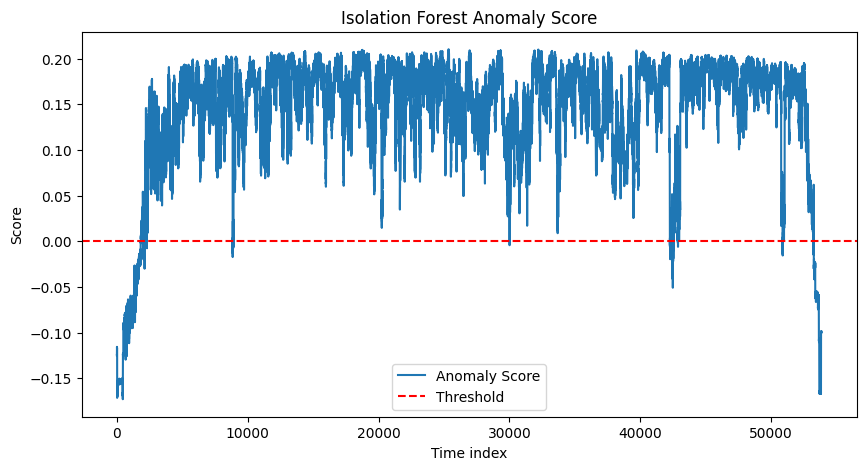

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered["iso_score"], label="Anomaly Score")
plt.axhline(y=0, color='r', linestyle='--', label="Threshold")
plt.legend()
plt.title("Isolation Forest Anomaly Score")
plt.xlabel("Time index")
plt.ylabel("Score")
plt.show()

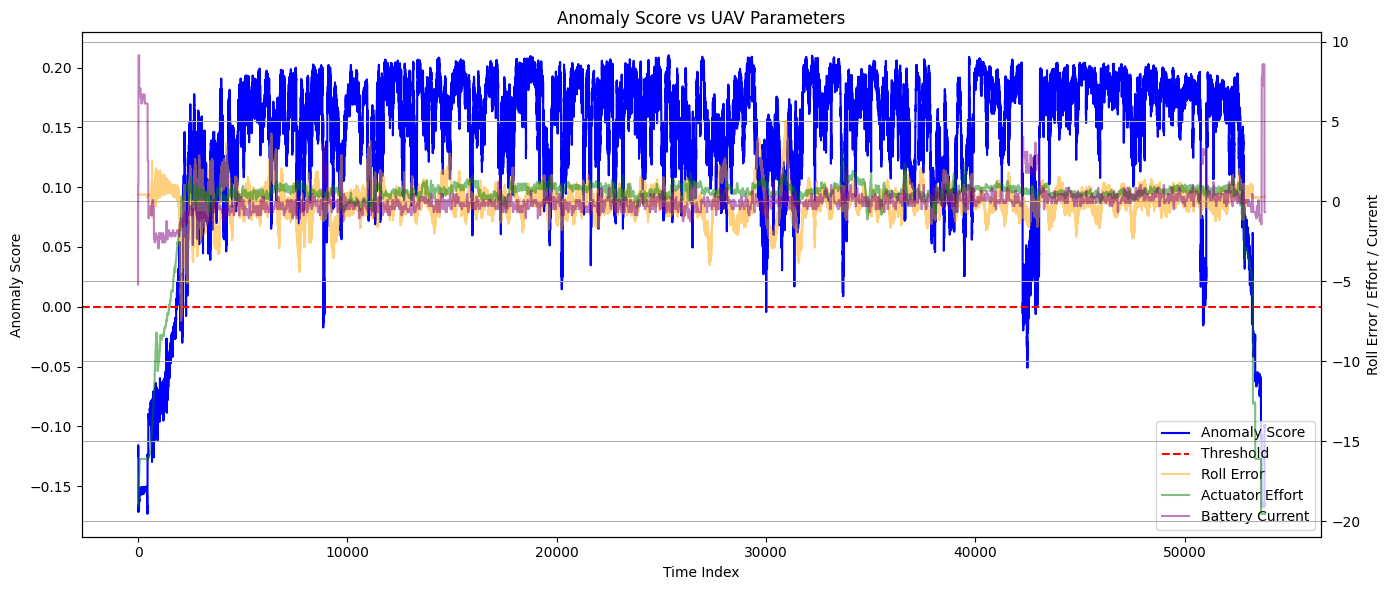

In [7]:
df_filtered["actuator_effort"] = df_filtered[["output[0]", "output[1]", "output[2]"]].sum(axis=1)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df_filtered["iso_score"], label="Anomaly Score", color='blue')
ax1.axhline(0, color='red', linestyle='--', label='Threshold')
ax1.set_ylabel("Anomaly Score")
ax1.set_xlabel("Time Index")

# Twin Y axis for roll_error
ax2 = ax1.twinx()
ax2.plot(df_filtered["roll_error"], label="Roll Error", color='orange', alpha=0.5)
ax2.plot(df_filtered["actuator_effort"], label="Actuator Effort", color='green', alpha=0.5)
ax2.plot(df_filtered["current_a"], label="Battery Current", color='purple', alpha=0.5)
ax2.set_ylabel("Roll Error / Effort / Current")

# Legend handling for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.title("Anomaly Score vs UAV Parameters")
plt.grid(True)
plt.tight_layout()
plt.show()


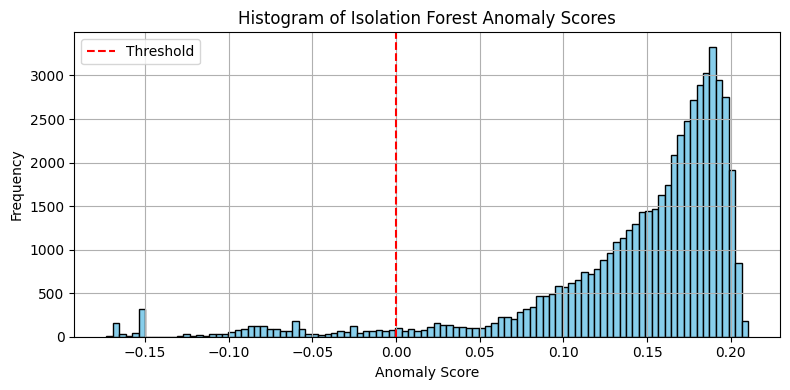

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(df_filtered["iso_score"], bins=100, color='skyblue', edgecolor='k')
plt.axvline(0, color='red', linestyle='--', label='Threshold')
plt.title("Histogram of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Extract indices where anomaly score < 0
anomalies = df_filtered[df_filtered["iso_score"] < 0]
anomaly_times = anomalies["timestamp"]

# Optional: Save for review in QGroundControl or PX4 Flight Review
anomalies[["timestamp", "iso_score"]].to_csv("anomaly_timestamps.csv", index=False)


In [19]:
import joblib
joblib.dump(iso_forest, 'Isolation_forest_model.pkl')

['Isolation_forest_model.pkl']